**Set Up Packages**

In [1]:
# Run this if geemap is not yet installed
import subprocess
#subprocess.check_call(["python", '-m', 'pip', 'install', 'geemap'])
#subprocess.check_call(["python", '-m', 'pip', 'install', 'ee'])

import geemap
Map = geemap.Map()
import ee
ee.Authenticate()
ee.Initialize()

**Set Input parameters and Get Image Collection**


In [2]:
# Get the mask polygon from ee.Asset
ee_asset = ee.FeatureCollection('projects/ee-karlos/assets/sar_ship_mask')
aoi = ee_asset.filter(ee.Filter.eq('orbit_stat', 'ascending'))

# Set up a function to clip the images within the aoi
def clip_to_aoi(imagecollection):
  return imagecollection.clip(aoi)

# Get Image Stack
s1_collection = ee.ImageCollection('COPERNICUS/S1_GRD')  \
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')) \
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH')) \
    .filter(ee.Filter.eq('instrumentMode', 'IW'))  \
    .filterDate('2023-12-01', '2023-12-31')\
    .filterBounds(aoi)\
    .filterMetadata('orbitProperties_pass', 'equals', 'ASCENDING')\
    .map(clip_to_aoi)

# If multiple time range is required, use this format:
# Yr2022 =  ee.Filter.date('2022-06-01', '2022-09-01')
# Yr2023 =  ee.Filter.date('2023-06-01', '2023-09-01')
# TimeFilter = ee.Filter.Or(Yr2022,Yr2023)

**Image Pre-processing**

In [3]:
# Change the image values to float type
s1_collection = s1_collection.map(lambda image: image.toFloat())

# Get Track Numbers of the Images (more tracks = increase complexity)
track_num = s1_collection.aggregate_array('relativeOrbitNumber_start')
#track_num.distinct()

# Get the most common orbital track from the initial image stack (best track to use for training the model)
best_track = track_num.reduce(ee.Reducer.mode())
best_track = ee.Number(best_track)

# Filter the image stack to include images only for this track
s1_collection = s1_collection.filterMetadata('relativeOrbitNumber_start', 'equals', best_track)

# Save all the image properties as a list so that the final images can have metadata appended.
# This step is needed because metadata will be removed after the LEE filter is applied
savedSystemIndexList = s1_collection.aggregate_array('system:index')
savedOrbitPropertiesPassList = s1_collection.aggregate_array('orbitProperties_pass')
savedRelativeOrbitStartList = s1_collection.aggregate_array('relativeOrbitNumber_start')
savedTimeStartList = s1_collection.aggregate_array('system:time_start')

**Apply a 7x7 Refined LEE Filter for de-speckling SAR images**

In [4]:
# Set Up a 7x7 Refined LEE Filter
# Source: https://mygeoblog.com/2018/02/16/timeseries-with-sar/
# Convert image from db to natural units:
toNatural = lambda img: ee.Image(10.0).pow(img.select(0).divide(10.0))

# After running the filter, convert the natural units back to dB
toDB = lambda img: ee.Image(img).log10().multiply(10.0)

def RefinedLee(img):
  # img must be in natural units, i.e. not in dB!
  # Set up a 7x7 kernel
  myimg = toNatural(img)
  weights7 = ee.List.repeat(ee.List.repeat(1,7),7)
  kernel7 = ee.Kernel.fixed(7,7, weights7, 1, 1, False)
  mean7 = myimg.reduceNeighborhood(ee.Reducer.mean(), kernel7)
  variance7 = myimg.reduceNeighborhood(ee.Reducer.variance(), kernel7)

  # Use a sample of the 7x7 windows inside a 15x15 windows to determine gradients and directions
  sample_weights = ee.List([
      [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
      [0,1,0,1,0,1,0,1,0,1,0,1,0,1,0],
      [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
      [0,1,0,1,0,1,0,1,0,1,0,1,0,1,0],
      [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
      [0,1,0,1,0,1,0,1,0,1,0,1,0,1,0],
      [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
      [0,1,0,1,0,1,0,1,0,1,0,1,0,1,0],
      [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
      [0,1,0,1,0,1,0,1,0,1,0,1,0,1,0],
      [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
      [0,1,0,1,0,1,0,1,0,1,0,1,0,1,0],
      [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
      [0,1,0,1,0,1,0,1,0,1,0,1,0,1,0],
      [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
  ])
  sample_kernel = ee.Kernel.fixed(15,15, sample_weights, 7,7, False)

  # Calculate mean and variance for the sampled windows and store as 9 bands
  sample_mean = mean7.neighborhoodToBands(sample_kernel)
  sample_var = variance7.neighborhoodToBands(sample_kernel)

  # Determine the 4 gradients for the sampled windows
  gradients = sample_mean.select(1).subtract(sample_mean.select(7)).abs()
  gradients = gradients.addBands(sample_mean.select(6).subtract(sample_mean.select(2)).abs())
  gradients = gradients.addBands(sample_mean.select(3).subtract(sample_mean.select(5)).abs())
  gradients = gradients.addBands(sample_mean.select(0).subtract(sample_mean.select(8)).abs())

  # And find the maximum gradient amongst gradient bands
  max_gradient = gradients.reduce(ee.Reducer.max())

  # Create a mask for band pixels that are the maximum gradient
  gradmask = gradients.eq(max_gradient)

  # duplicate gradmask bands: each gradient represents 2 directions
  gradmask = gradmask.addBands(gradmask)

  # Determine the 8 directions
  directions = sample_mean.select(1).subtract(sample_mean.select(4)).gt(sample_mean.select(4).subtract(sample_mean.select(7))).multiply(1)
  directions = directions.addBands(sample_mean.select(6).subtract(sample_mean.select(4)).gt(sample_mean.select(4).subtract(sample_mean.select(2))).multiply(2))
  directions = directions.addBands(sample_mean.select(3).subtract(sample_mean.select(4)).gt(sample_mean.select(4).subtract(sample_mean.select(5))).multiply(3))
  directions = directions.addBands(sample_mean.select(0).subtract(sample_mean.select(4)).gt(sample_mean.select(4).subtract(sample_mean.select(8))).multiply(4))
  # The next 4 are the not() of the previous 4
  directions = directions.addBands(directions.select(0).Not().multiply(5))
  directions = directions.addBands(directions.select(1).Not().multiply(6))
  directions = directions.addBands(directions.select(2).Not().multiply(7))
  directions = directions.addBands(directions.select(3).Not().multiply(8))

  # Mask all values that are not 1-8
  directions = directions.updateMask(gradmask)

  # "collapse" the stack into a singe band image (due to masking, each pixel has just one value (1-8) in it's directional band, and is otherwise masked)
  directions = directions.reduce(ee.Reducer.sum())
  sample_stats = sample_var.divide(sample_mean.multiply(sample_mean))

  # Calculate localNoiseVariance
  sigmaV = sample_stats.toArray().arraySort().arraySlice(0,0,5).arrayReduce(ee.Reducer.mean(), [0])

  # Set up the 15*15 kernels for directional statistics
  rect_weights = ee.List.repeat(ee.List.repeat(0,15),7).cat(ee.List.repeat(ee.List.repeat(1,15),8))
  diag_weights = ee.List([
      [1,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
      [1,1,0,0,0,0,0,0,0,0,0,0,0,0,0],
      [1,1,1,0,0,0,0,0,0,0,0,0,0,0,0],
      [1,1,1,1,0,0,0,0,0,0,0,0,0,0,0],
      [1,1,1,1,1,0,0,0,0,0,0,0,0,0,0],
      [1,1,1,1,1,1,0,0,0,0,0,0,0,0,0],
      [1,1,1,1,1,1,1,0,0,0,0,0,0,0,0],
      [1,1,1,1,1,1,1,1,0,0,0,0,0,0,0],
      [1,1,1,1,1,1,1,1,1,0,0,0,0,0,0],
      [1,1,1,1,1,1,1,1,1,1,0,0,0,0,0],
      [1,1,1,1,1,1,1,1,1,1,1,0,0,0,0],
      [1,1,1,1,1,1,1,1,1,1,1,1,0,0,0],
      [1,1,1,1,1,1,1,1,1,1,1,1,1,0,0],
      [1,1,1,1,1,1,1,1,1,1,1,1,1,1,0],
      [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]
  ])

  rect_kernel = ee.Kernel.fixed(15,15, rect_weights, 7, 7, False)
  diag_kernel = ee.Kernel.fixed(15,15, diag_weights, 7, 7, False)

  # Create stacks for mean and variance using the original kernels. Mask with relevant direction.
  dir_mean = myimg.reduceNeighborhood(ee.Reducer.mean(), rect_kernel).updateMask(directions.eq(1))
  dir_var = myimg.reduceNeighborhood(ee.Reducer.variance(), rect_kernel).updateMask(directions.eq(1))

  dir_mean = dir_mean.addBands(myimg.reduceNeighborhood(ee.Reducer.mean(), diag_kernel).updateMask(directions.eq(2)))
  dir_var = dir_var.addBands(myimg.reduceNeighborhood(ee.Reducer.variance(), diag_kernel).updateMask(directions.eq(2)))

  # and add the bands for rotated kernels
  for i in range(1, 8):
    dir_mean = dir_mean.addBands(myimg.reduceNeighborhood(ee.Reducer.mean(), rect_kernel.rotate(i)).updateMask(directions.eq(2*i+1)))
    dir_var = dir_var.addBands(myimg.reduceNeighborhood(ee.Reducer.variance(), rect_kernel.rotate(i)).updateMask(directions.eq(2*i+1)))
    dir_mean = dir_mean.addBands(myimg.reduceNeighborhood(ee.Reducer.mean(), diag_kernel.rotate(i)).updateMask(directions.eq(2*i+2)))
    dir_var = dir_var.addBands(myimg.reduceNeighborhood(ee.Reducer.variance(), diag_kernel.rotate(i)).updateMask(directions.eq(2*i+2)))

  # "collapse" the stack into a single band image (due to masking, each pixel has just one value in it's directional band, and is otherwise masked)
  dir_mean = dir_mean.reduce(ee.Reducer.sum())
  dir_var = dir_var.reduce(ee.Reducer.sum())

  # A finally generate the filtered value
  varX = dir_var.subtract(dir_mean.multiply(dir_mean).multiply(sigmaV)).divide(sigmaV.add(1.0))
  b = varX.divide(dir_var)
  result = dir_mean.add(b.multiply(myimg.subtract(dir_mean)))
  return ee.Image(toDB(result.arrayGet(0))).toFloat()

# The bands for VV and VH are both named 'sum' after the Lee filter is applied, and are renamed back to VV and VH afterwards
s1_LeeVV = s1_collection.select('VV').map(RefinedLee).select(['sum'], ['VV'])
s1_LeeVH = s1_collection.select('VH').map(RefinedLee).select(['sum'], ['VH'])

# Save the angle band and a dummy collection with no bands
s1_angle = s1_collection.select(['angle'])
dummy = s1_collection.select([])

# Creating the filter for the joins
filter = ee.Filter.equals(leftField = 'system:index', rightField = 'system:index')

# Create the simple join
simpleJoin = ee.Join.inner();

# Function used with the inner joins
doFeaturePrimarySecondary = lambda feature: ee.Image.cat(feature.get('primary'), feature.get('secondary'))

# Create the inner join for merging the VV and VH collections
# Join the VV and VH into a single image collection
innerJoin = ee.ImageCollection(simpleJoin.apply(s1_LeeVV, s1_LeeVH, filter))
s1_VV_VH = innerJoin.map(doFeaturePrimarySecondary)

# Create the inner join for merging the angle and dummy collections
# Join angle and dummy into a single image collection
innerJoin2 = ee.ImageCollection(simpleJoin.apply(s1_angle, dummy, filter))
s1_angle_dummy = innerJoin2.map(doFeaturePrimarySecondary)

# Create the inner join for merging the angle and dummy collections
# Join VV_VH and angle_dummy into a single image collection
innerJoin3 = ee.ImageCollection(simpleJoin.apply(s1_VV_VH, s1_angle_dummy, filter))
s1_collection = innerJoin3.map(doFeaturePrimarySecondary)

# Make a list of index values and turn the image collection into a list
indexList = ee.List.sequence(0, s1_collection.size().subtract(1))
listOfImages = s1_collection.toList(s1_collection.size())

# Function for adding the properties back to the images
def addProperties(index):
  # Get the image at the index
  image = ee.Image(listOfImages.get(index))
  # Get the properties from the saved lists based on the index
  systemIndex = savedSystemIndexList.get(index)
  orbitPropertiesPass = savedOrbitPropertiesPassList.get(index)
  relativeOrbitStart = savedRelativeOrbitStartList.get(index)
  timeStart = savedTimeStartList.get(index)

  # Change the properties to the format that is needed for the exported image name and add them back to the image
  image = image.set('savedSystemIndex', ee.String(systemIndex).slice(0, 32))
  image = image.set('savedOrbitPropertiesPass', ee.String(orbitPropertiesPass).slice(0, 3))
  image = image.set('savedRelativeOrbitStart', (ee.Number(relativeOrbitStart).toByte()).format())
  image = image.set('system:time_start', ee.Number(timeStart))
  return image

# Now all properties are returned to the images
s1_collection_finalized = ee.ImageCollection(indexList.map(addProperties))

###### Mosaic adjacent images that were taken on the same day ###########
# Source: https://gis.stackexchange.com/questions/369057/google-earth-engine-roi-area-falling-outside-partial-coverage-by-sentinel-1-tile/370455#370455
def makeMosaics(image):
  thisImage = ee.Image(image)
  date = ee.Date(thisImage.get('system:time_start'))
  orbitPropertiesPass = thisImage.get('savedOrbitPropertiesPass')
  filtered_stack = s1_collection_finalized  \
    .filterDate(date, date.advance(1,'day'))  \
    .filter(ee.Filter.eq('savedOrbitPropertiesPass', orbitPropertiesPass))
  # Mosaic the filtered images together and copy the metadata/image properties
  return ee.Image(filtered_stack.mosaic().copyProperties(image, ['system:time_start', 'savedSystemIndex', 'savedOrbitPropertiesPass', 'savedRelativeOrbitStart']))

s1_collection_mosaic = s1_collection_finalized.map(makeMosaics)

###### Remove images that were acquired but processed at different dates (a Sentinel-1 problem)###########
# Source: https://gis.stackexchange.com/questions/336257/filter-out-duplicate-sentinel-2-images-form-earth-engine-image-collection-by-dat

# Generate a list from the mosaiced images
compareDateListOriginal = s1_collection_mosaic.toList(s1_collection_mosaic.size())
# Create an list with a dummy image with a dummy date
startList = ee.List([ee.Image().set('system:time_start', ee.Date(0))])
# Add the dummy list to the beginning of the mosaiced list
compareDateList = startList.cat(compareDateListOriginal)

# Function to find all the duplicates
def findDuplicates(image):
  # Index of the image in the list
  index = compareDateList.indexOf(image)
  # Get the previous image in the list
  prevImage = ee.Image(compareDateList.get(index.subtract(1)))
  # Compare date of the image with the date of the previous image in the list
  date1 = ee.Date(image.get('system:time_start')).format('Y-M-d')
  date2 = ee.Date(prevImage.get('system:time_start')).format('Y-M-d')
  duplicateCheck = ee.Algorithms.IsEqual(date1, date2)
  # String reprisenting if image is a duplicate or not
  isDuplicate = ee.String('')
  # Set the string
  isDuplicate = ee.String(ee.Algorithms.If(condition = duplicateCheck, trueCase = 'duplicate', falseCase = 'no duplicate'))
  return image.set('duplicate', isDuplicate)

# Find all the duplicates and then filter to remove them
s1_collection_check = s1_collection_mosaic.map(findDuplicates)
s1_collection_no_duplicates = s1_collection_check.filter(ee.Filter.eq('duplicate', 'no duplicate'))

# Create an "ID" field for the image stack
# Make a list of id values the size of s1_collection (mosaic, no duplicates)
list_of_ids = ee.List.sequence(0, s1_collection_no_duplicates.size().subtract(1))
# Turn s1_collection into a list
stack_list = s1_collection_no_duplicates.toList(s1_collection_no_duplicates.size())

# Function for adding the index value as the property ID (unique id# = system index#)
def addID(index):
  image = ee.Image(stack_list.get(index))
  indexNum = ee.Number(index)
  image = image.set('ID', indexNum)
  return image
s1_collection = ee.ImageCollection(list_of_ids.map(addID))

In [5]:
# Get band names of the first image
band_names = s1_collection.first().bandNames()
band_names

In [6]:
sample_img = s1_collection.filter(ee.Filter.stringContains('system:index', 'S1A_IW_GRDH_1SDV_20231203T020307_20231203T020332_051484_0636C5')).first()
sample_img = sample_img.select('VH')

**Use the "Otsu Thresholding" method to find the threshold value that best
differentiates water and ships**

In [7]:
# Source: https://github.com/gee-community/geemap/blob/master/examples/notebooks/otsu.ipynb
# Inspiration: https://medium.com/google-earth/otsus-method-for-image-segmentation-f5c48f405e
# Otsu’s method is a means of automatically finding an optimal threshold based on the observed distribution of pixel values (Otsu. 1979).

# Create functions to do the following operations in order:
# 1. Histogram calculation
# 2. Class Variance calculation
# 3. Threshold selection
# 4. Binarization (create a binary image that classifies water vs. ships)

# Return the DN that maximizes interclass variance
def otsu(histogram):
    counts = ee.Array(ee.Dictionary(histogram).get("histogram"))
    means = ee.Array(ee.Dictionary(histogram).get("bucketMeans"))
    size = means.length().get([0])
    total = counts.reduce(ee.Reducer.sum(), [0]).get([0])
    sum = means.multiply(counts).reduce(ee.Reducer.sum(), [0]).get([0])
    mean = sum.divide(total)

    indices = ee.List.sequence(1, size)

    # Compute between sum of squares, where each mean partitions the data.
    def func_xxx(i):
        aCounts = counts.slice(0, 0, i)
        aCount = aCounts.reduce(ee.Reducer.sum(), [0]).get([0])
        aMeans = means.slice(0, 0, i)
        aMean = (
            aMeans.multiply(aCounts)
            .reduce(ee.Reducer.sum(), [0])
            .get([0])
            .divide(aCount)
        )
        bCount = total.subtract(aCount)
        bMean = sum.subtract(aCount.multiply(aMean)).divide(bCount)
        return aCount.multiply(aMean.subtract(mean).pow(2)).add(
            bCount.multiply(bMean.subtract(mean).pow(2))
        )

    bss = indices.map(func_xxx)

    # Return the mean value corresponding to the maximum BSS.
    return means.sort(bss).get([-1])


# Apply this threshold to extract ships, incorporate the otsu function insde
# a function
def extract_ship(image):
    histogram = image.reduceRegion(
        **{
            "reducer": ee.Reducer.histogram(255, 2),
            "geometry": aoi,
            "scale": 10,
            "bestEffort": True,
            "tileScale": 16
        }
    )
    threshold = otsu(histogram.get("VH"))
    ship = image.gt(threshold).selfMask()
    return ship.set({"threshold": threshold})

In [8]:
# Apply the Otsu-thresholding functions
ship_raster = extract_ship(sample_img)
# The thresholded image still contains a lot of noise
# But we can convert them from raster into polygon, selecting those that have at least 100 pixels
ship_vector = ship_raster.reduceToVectors(
    reducer= ee.Reducer.countEvery(),
    geometry= aoi,
    scale=10,
    maxPixels=1e13
)

# Remove noise (small clusters that are <500 pixels)
cleaned_ships = ship_vector.filter(ee.Filter.gt('count',500))

In [9]:
# Count the number of polygons inside the FeatureCollection (num_polys = num_ships)
cleaned_ships.size()


**Quick Visualization**

In [10]:
Map.addLayer(cleaned_ships, {}, "cleaned_ships")
Map.centerObject(aoi, zoom=13)
Map

Map(center=[49.30663244333951, -123.21560360387147], controls=(WidgetControl(options=['position', 'transparent…

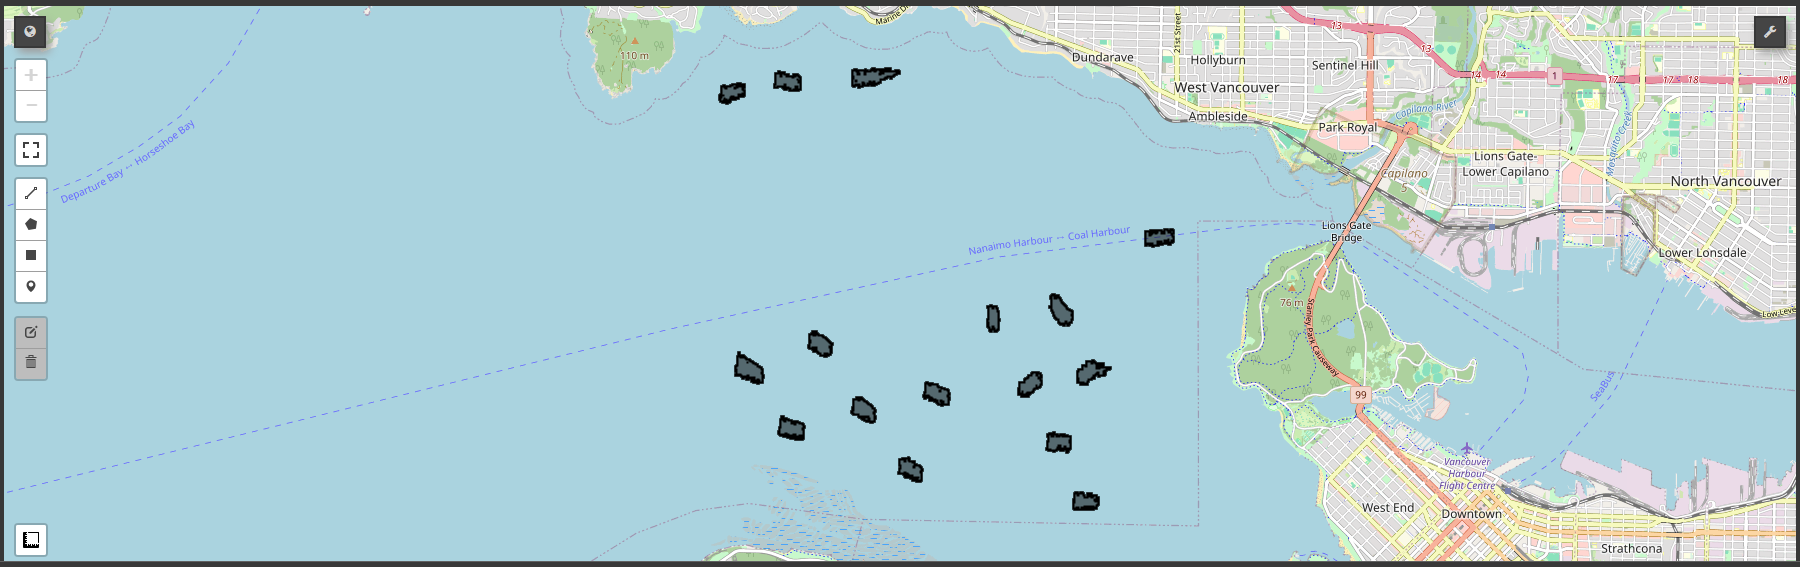